In [1]:
#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI

def split_data(data, ratio=0.7): # when the ratio argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\melih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\melih\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
random.seed(42)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['the', 'summer', 'movie', 'season', 'is', 'always', ...], 'pos')


In [3]:
#preprocessing
import string
from nltk.stem import WordNetLemmatizer

#removal of digits, punctuation and stopwords
puncts = string.punctuation
stop_words = stopwords.words("english")

lemma = WordNetLemmatizer()

training_data = [([lemma.lemmatize(word) for word in doc if (word not in puncts and word not in stop_words and word.isalpha())],label) for doc,label in training_data]
testing_data = [([lemma.lemmatize(word) for word in doc if (word not in puncts and word not in stop_words and word.isalpha())],label) for doc,label in testing_data]


In [4]:
def word_list_generator(training_data,list_length=10):
    '''
    A method to generate lists of given length from both tags which are positive and negative.
    
    :param training_data: data from which the lists will generated
    :param list_length: the length of the lists
    
    :return: positive and negative word lists

    '''    
    training_freqs = [(FreqDist(doc),label) for doc,label in training_data]
    pos_word_freqs = FreqDist()
    neg_word_freqs = FreqDist()
    
    #finding out the frequencies of words in each category
    for doc,label in training_freqs:
        if label == 'pos':
            pos_word_freqs += doc
        else:
            neg_word_freqs += doc
            
    #separation the pairs into two seperate lists
    #single underscore here is used as a throw-away variable
    pos_words, _ = zip(*pos_word_freqs.most_common(list_length))
    neg_words, _ = zip(*neg_word_freqs.most_common(list_length))
    
    return pos_words, neg_words

pos_words, neg_words = word_list_generator(training_data)

In [5]:
pos_words

('film',
 'one',
 'movie',
 'character',
 'like',
 'time',
 'scene',
 'make',
 'story',
 'get')

#### Basic Word List Classifier

This is a very straightforward algorithm to classify text data. What it does is to look at the lists -generated by the `word_list_generator` method- and find the common words in the lists and in the test data. Then, if it finds more match in the positive lists than the negative, it predicts the data as positive. Otherwise, negative. 

In [6]:
class WordListClassifier(ClassifierI):
    
    def __init__(self):
        pass
    
    def train(self, training_data, list_length=10):
        self.pos_words, self.neg_words = word_list_generator(training_data,list_length)
    
    def classify(self, test_data):
        score = 0
        
        for word in test_data:
            if word in self.pos_words:
                score += 1
            if word in self.neg_words:
                score -= 1
        if score > 0:
            return 'pos'
        elif score < 0:
            return 'neg'
        else:
            return random.choice(['pos','neg'])
        
    def labels(self):
        return (['pos','neg'])

In [7]:
wl_cls = WordListClassifier()
wl_cls.train(training_data)
wl_preds = wl_cls.classify_many([doc for doc,_ in testing_data])

true_labels = [label for _,label in testing_data]

In [8]:
#confusion matrix and metrics to assess the model's performance
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix(preds,true_labels):
    ConfusionMatrixDisplay.from_predictions(true_labels,preds)
    plt.title("Confusion Matrix")
    plt.show()
    
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for i in range(len(preds)):
        if preds[i] == true_labels[i]:
            if preds[i] == 'pos':
                tp += 1
            else:
                tn += 1
        else:
            if preds[i] == 'pos':
                fp += 1
            else:
                fn += 1
    return (tp, tn, fp, fn)

def metrics(tp, tn, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    print(pd.DataFrame({"Metrics":[precision,recall,f1_score,accuracy]},index=['Precision','Recall','F1 Score','Accuracy']))

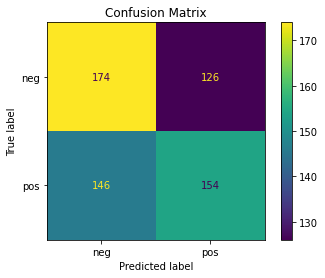

            Metrics
Precision  0.550000
Recall     0.513333
F1 Score   0.531034
Accuracy   0.546667


In [9]:
tp, tn, fp, fn = confusion_matrix(wl_preds,true_labels)
metrics(tp, tn, fp, fn)

#### Naive Baye